In [31]:
from datetime import datetime
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Point cloud name
DATASET = 'paris_lille'
CLOUD = 'Lille_0'

# Input folder and timestamp to search for. Timestamp can be "latest" or a specific timestmap
FOLDER = os.path.join("out", CLOUD)
TIMESTAMP = 'latest'

# Output folder for the plots
PLOT_FOLDER = os.path.join("plots", "05_12_2024", "kernel_comparison", DATASET, CLOUD)
os.makedirs(PLOT_FOLDER, exist_ok=True)

# Function to get the file based on the specified timestamp in the filename
def get_file_by_date(folder, date_str):
    # Get all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder, "*.csv"))
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in the folder: {folder}")
    
    if TIMESTAMP == 'latest':
        # Parse filenames and find the latest based on the timestamp in the name
        latest_file = max(csv_files, key=lambda x: datetime.strptime(
            '-'.join(x.split('-')[1:]).replace('.csv', ''),  # Join list and then replace
            "%Y-%m-%d-%H:%M:%S"  # Correct datetime format
        ))
        print(f"Loading latest file: {latest_file}")
        return latest_file
    else:
        # Check for exact match with the date_str in the filename (ignoring the prefix)
        for file in csv_files:
            filename = os.path.basename(file)
            timestamp_str = filename.split('-')[1:]  # Split to get timestamp part
            timestamp_str = '-'.join(timestamp_str).replace('.csv', '')  # Rebuild timestamp string
            
            if date_str == timestamp_str:
                print(f"Loading file: {file}")
                return file
        raise FileNotFoundError(f"File with date '{date_str}' not found in folder: {folder}")

In [32]:
# Read the file and put into pandas dataframe
data = get_file_by_date(FOLDER, TIMESTAMP)
df = pd.read_csv(data)

# Convert times to milliseconds
df['mean'] = df['mean'] * 1000
df['stdev'] = df['stdev'] * 1000

# Set the style
plt.style.use('default')
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.2)

# Define a consistent color palette for 'octree' categories
octree_types = df['octree'].unique()
palette = sns.color_palette("Set2", len(octree_types))
color_dict = dict(zip(octree_types, palette))

# Create a function for adding execution details to plot titles
def get_execution_details(data):
    search_size = data['num_searches'].iloc[0]
    repeats = data['repeats'].iloc[0]
    return f'\n\nSearch Size: {search_size:,} points, Repeats: {repeats}\n\nPoint cloud {CLOUD} in dataset {DATASET}'

Loading latest file: out/Lille_0/Lille_0-2024-12-10-14:03:38.csv


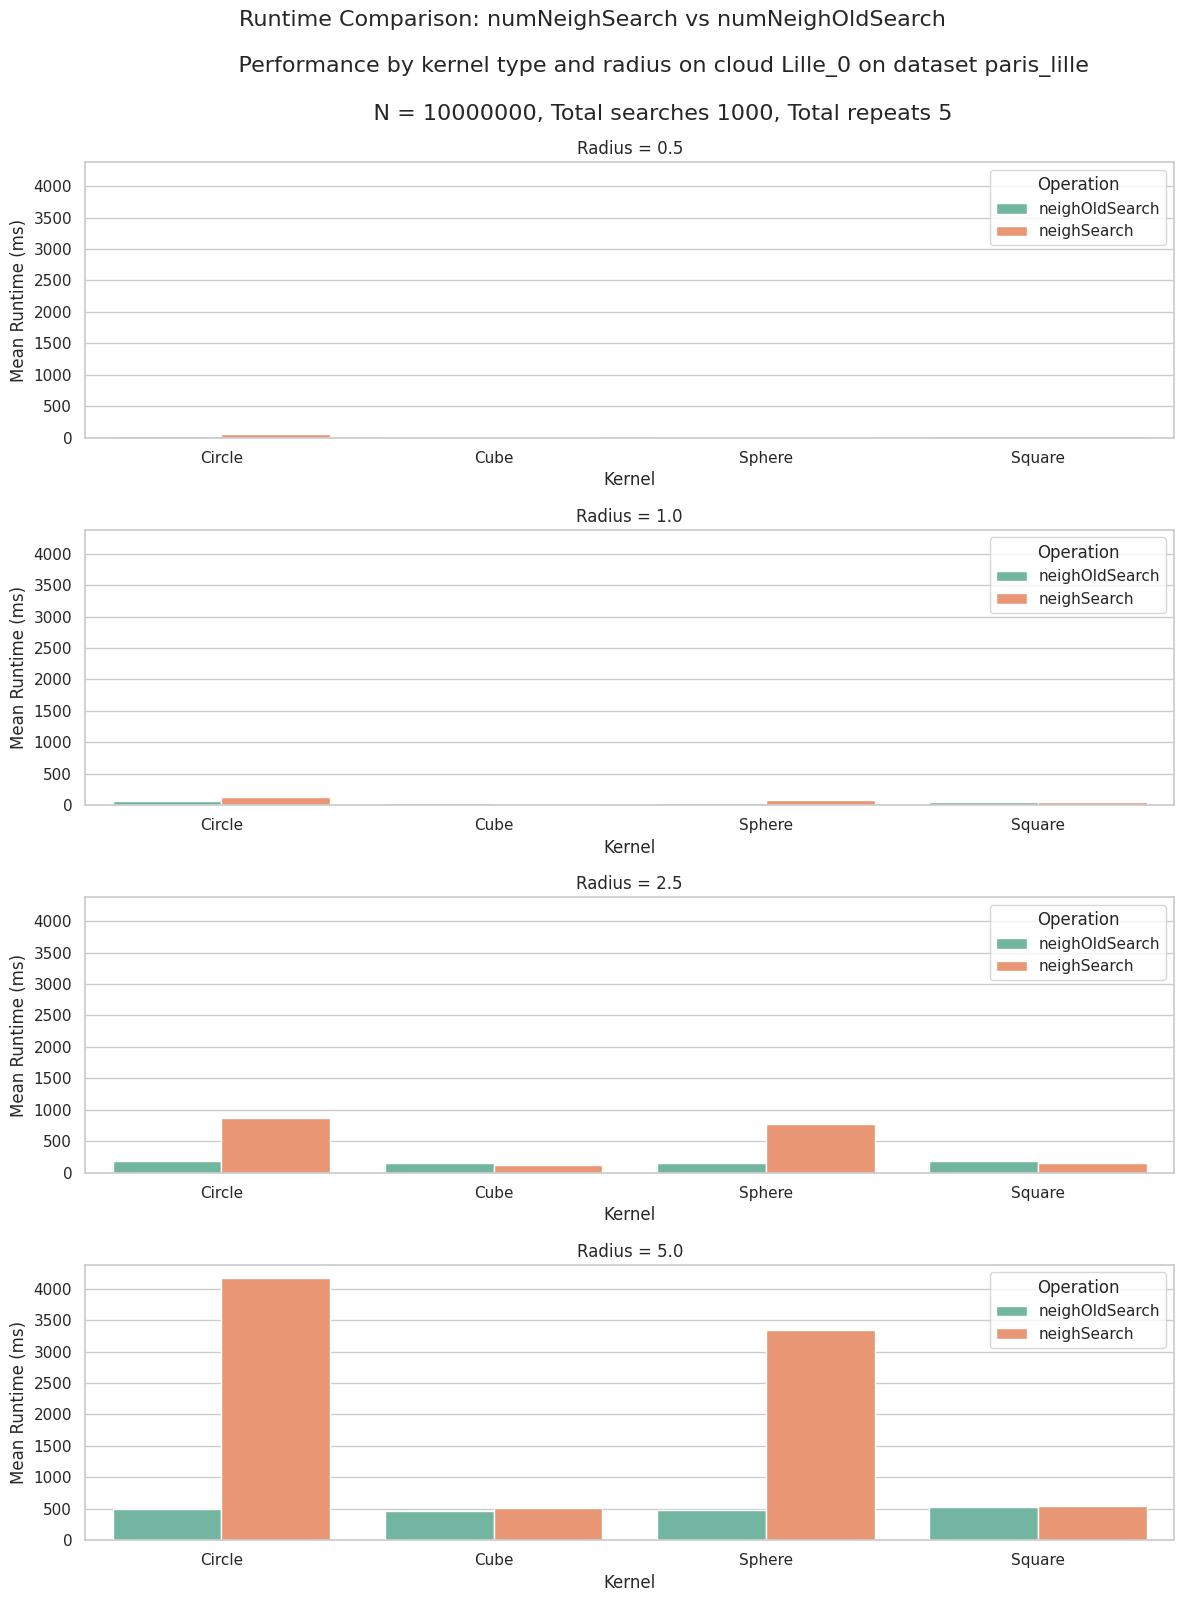

In [33]:
def plot_runtime_comparison(df, operations):
    # Filter for the two operations
    df = df[df['operation'].isin(operations)]
    
    # Unique radii and kernels
    radii = sorted(df['radius'].unique())
    kernels = df['kernel'].unique()
    
    # Set up the color palette
    sns.set_theme(style="whitegrid")
    palette = sns.color_palette("Set2", len(operations))
    nsearches = df['num_searches'].iloc[0] # The number of searches is in every row of the dataset at column num_searches
    nrepeats = df['repeats'].iloc[0] # The number of repeats is in every row of the dataset at column repeats
    npoints = df['npoints'].iloc[0] # The number of points is in every row of the dataset at column npoints
    # Create subplots for each radius
    fig, axes = plt.subplots(len(radii), 1, figsize=(12, 4 * len(radii)), sharey=True)
    if len(radii) == 1:
        axes = [axes]  # Handle single radius case
    
    # Plot each radius
    for ax, radius in zip(axes, radii):
        # Filter data for the current radius
        radius_data = df[df['radius'] == radius]
        
        # Pivot the data for seaborn compatibility
        pivoted = radius_data.pivot_table(
            index='kernel', 
            columns='operation', 
            values='mean'
        ).reset_index()
        
        # Melt the data for seaborn
        melted = pivoted.melt(id_vars='kernel', var_name='Operation', value_name='Runtime (ms)')
        
        # Create the barplot
        sns.barplot(
            data=melted, 
            x='kernel', 
            y='Runtime (ms)', 
            hue='Operation', 
            palette=palette, 
            ax=ax
        )
        
        # Set plot labels and title
        ax.set_title(f"Radius = {radius}")
        ax.set_xlabel("Kernel")
        ax.set_ylabel("Mean Runtime (ms)")
    
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    
    # Overall title with adjusted y parameter
    fig.suptitle(f"""Runtime Comparison: numNeighSearch vs numNeighOldSearch\n
                    Performance by kernel type and radius on cloud {CLOUD} on dataset {DATASET}\n
                    N = {npoints}, Total searches {nsearches}, Total repeats {nrepeats}""", 
                 y=1, fontsize=16)
    
    return fig

# Generate the plot
fig = plot_runtime_comparison(df, ['neighSearch', 'neighOldSearch'])
plt.show()

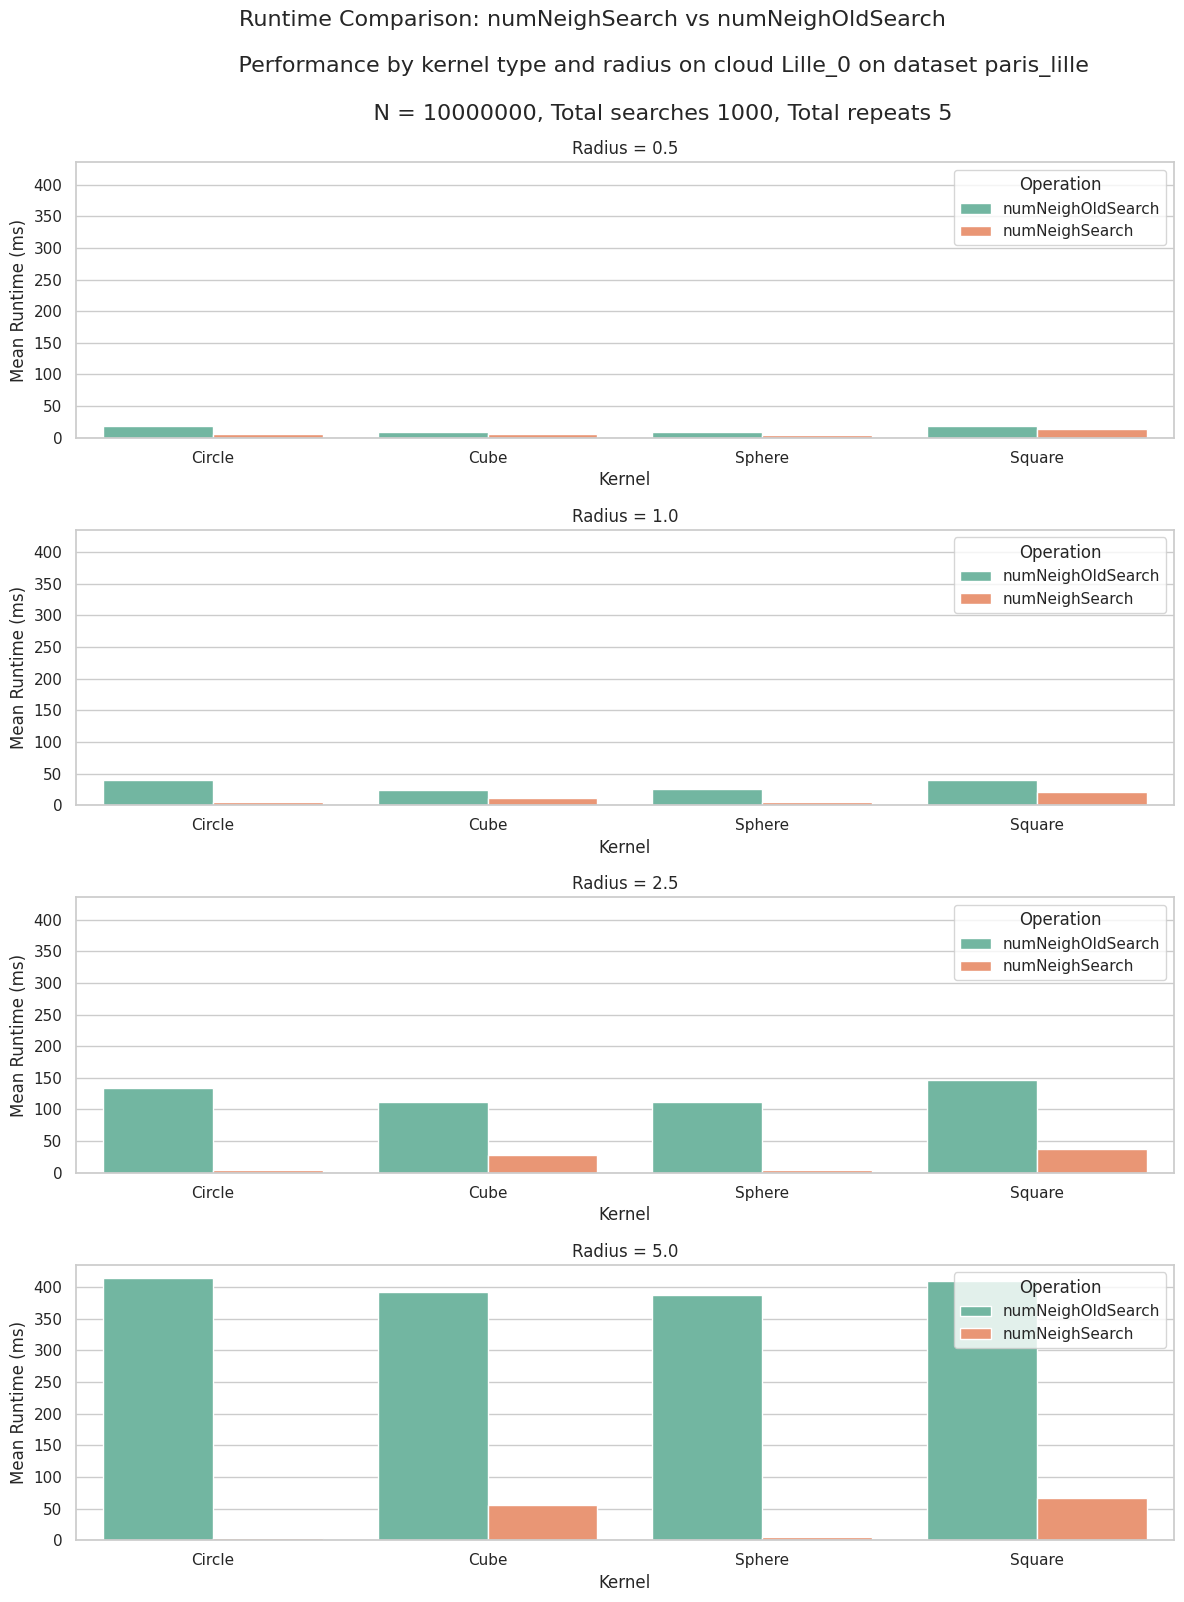

In [34]:
# Generate the plot
fig = plot_runtime_comparison(df, ['numNeighSearch', 'numNeighOldSearch'])
plt.show()